# [ PART 03. 통계분석 ] - 4장. 분산분석 (ANOVA)

## - 불러올 패키지 목록

In [1]:
# 데이터 핸들링을 위한 패키지
import numpy as np
import pandas as pd

# 통계분석을 위해 사용하는 패키지
import scipy.stats
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd    # 사후검정 시 사용
from statsmodels.sandbox.stats.multicomp import MultiComparison    # MultiComparison을 활용한 사후검정 시 사용
from statsmodels.graphics.factorplots import interaction_plot    # 상호작용효과 그래프 출력 시 사용
import pingouin as pg    # 분산분석 시 사용, 패키지 설치는 pip install pingouin 실행
import scikit_posthocs as sp    # 사후검정 시 사용, 패키지 설치는 pip install scikit-posthocs


# 시각화를 위한 패키지
from matplotlib import pyplot as plt
import seaborn as sns

# %matplotlib inline 의 목적은 plt.show()함수가 호출되지 않은 경우에도 matplotlib 다이어그램을 렌더링하는 것이다.
# 그러나 현재 업데이트된 버전의 주피터 노트북 버전에서는 %matplotlib inline 를 사용하지 않더라도 Matplotlib 다이어그램을 개체로 표현한다.
# 따라서 굳이 필요하지는 않다. 그러나 코드를 깨끗하게 유지하고 자신이 만든 플롯을 호출하기 위해 여전히 관례적으로 권장된다.
%matplotlib inline

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

## 1. 일원배치 분산분석

In [2]:
df_iris = pd.read_csv( 'C:/Users/Administrator/GitHub/TIL/ADP_study/rawdata/iris.csv',
                         index_col = 'Unnamed: 0' )

In [3]:
# 컬럼이름에 섞여있는 '.' 을 '_' 로 변경
# statsmodels 패키지를 사용하여 일원분산 분석 실시할 때 오류 발생 방지

df_iris.rename( columns = {'Sepal.Length':'Sepal_Length',
                           'Sepal.Width':'Sepal_Width',
                           'Petal.Length':'Petal_Length',
                           'Petal.Width':'Petal_Width'},
                inplace = True )

df_iris

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,virginica
147,6.3,2.5,5.0,1.9,virginica
148,6.5,3.0,5.2,2.0,virginica
149,6.2,3.4,5.4,2.3,virginica


### 1.1. 등분산 검정

< 가설 설정 - 등분산성 검정 >
- 귀무가설(H0) : 두 집단의 분산이 동일하다.
- 대립가설(H1) : 두 집단의 분산이 동일하지 않다.

< 유의수준은 0.05 로 설정 >

In [4]:
df_one_anova = pd.DataFrame( df_iris,
                             columns = ['Sepal_Width', 'Species'] )

type1 = df_one_anova[ df_iris['Species'] == 'setosa' ]['Sepal_Width']
type2 = df_one_anova[ df_iris['Species'] == 'versicolor' ]['Sepal_Width']
type3 = df_one_anova[ df_iris['Species'] == 'virginica' ]['Sepal_Width']

#### 1.1.1. Bartlett's test

In [5]:
bartlett_test = stats.bartlett( type1, type2, type3 )

print( f" Statistic(Bartlett's test): {bartlett_test[0]:.3f} \n P-value: {bartlett_test[1]:.12f} " )

if bartlett_test[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.")
if bartlett_test[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.")
print()

 Statistic(Bartlett's test): 2.091 
 P-value: 0.351502800416 
 p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.



#### 1.1.2. Levene's test

In [6]:
levene_test = stats.levene( type1, type2, type3 )

print( f" Statistic(Levene's Test): {levene_test[0]:.3f} \n P-value: {levene_test[1]:.12f} " )

if levene_test[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.")
if levene_test[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.")
print()

 Statistic(Levene's Test): 0.590 
 P-value: 0.555517898474 
 p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.



In [7]:
# 분산의 동질성 검정 기준을 기본값 'median'이 아닌 'mean' 으로 변경할 경우

levene_test2 = stats.levene( type1, type2, type3,
                            center = 'mean' )

print( f" Statistic(Levene's Test): {levene_test[0]:.3f} \n P-value: {levene_test[1]:.12f} " )

if levene_test2[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.")
if levene_test2[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.")
print()

 Statistic(Levene's Test): 0.590 
 P-value: 0.555517898474 
 p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.



#### 1.1.3. Fligner’s test

In [8]:
fligner_test = stats.fligner( type1, type2, type3 )

print( f" Statistic(Fligner’s Test): {fligner_test[0]:.3f} \n P-value: {fligner_test[1]:.12f} " )

if fligner_test[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.")
if fligner_test[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.")
print()

 Statistic(Fligner’s Test): 0.912 
 P-value: 0.633750652353 
 p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.



### 1.2. one-way ANOVA
< 가설 설정 - ANOVA >
- 귀무가설(H0) : 세 가지 종의 Sepal.Width의 평균은 같다.
- 대립가설(H1) : 적어도 하나 이상의 종에 대한 Sepal.Width의 평균값에는 차이가 있다.

< 유의수준은 0.05 로 설정 >

#### 1.2.1. pingouin 패키지 사용

In [9]:
results = pg.anova( data = df_iris,
                    dv = 'Sepal_Width', between = 'Species',
                    detailed = True )

print(results)
print()

    Source         SS   DF        MS         F         p-unc       np2
0  Species  11.344933    2  5.672467  49.16004  4.492017e-17  0.400783
1   Within  16.962000  147  0.115388       NaN           NaN       NaN


#### 1.2.2. statsmodels 패키지 사용

In [10]:
df_one_anova = pd.DataFrame( df_iris,
                             columns = ['Sepal_Width', 'Species'] )

results = ols( 'Sepal_Width ~ C(Species)', data = df_one_anova ).fit()

print(results.summary())
print()

                            OLS Regression Results                            
Dep. Variable:            Sepal_Width   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     49.16
Date:                Fri, 16 Jul 2021   Prob (F-statistic):           4.49e-17
Time:                        22:10:31   Log-Likelihood:                -49.366
No. Observations:                 150   AIC:                             104.7
Df Residuals:                     147   BIC:                             113.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### 1.2.3. scipy.stats 패키지 사용

In [11]:
one_anova_result = stats.f_oneway(type1, type2, type3)

print( f' F-Value: {one_anova_result[0]:.4f}    P-value: {one_anova_result[1]:.28f}' )

if one_anova_result[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설을 채택. \n 세 가지 종의 Sepal.Width의 평균은 같다.")
if one_anova_result[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설을 기각. \n 적어도 하나 이상의 종에 대한 Sepal.Width의 평균값에는 차이가 있다.")
print()

 F-Value: 49.1600    P-value: 0.0000000000000000449201713331
 p-value < 0.05 이므로 귀무가설을 기각. 
 적어도 하나 이상의 종에 대한 Sepal.Width의 평균값에는 차이가 있다.



### 1.3. 사후 검정

#### 1.3.1. Tukey's HSD (Honest Significant Difference) test

##### 1.3.1.1. statsmodels 패키지의 pairwise_tukeyhsd() 패키지 활용

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    setosa versicolor   -0.658  0.001 -0.8189 -0.4971   True
    setosa  virginica   -0.454  0.001 -0.6149 -0.2931   True
versicolor  virginica    0.204 0.0088  0.0431  0.3649   True
------------------------------------------------------------



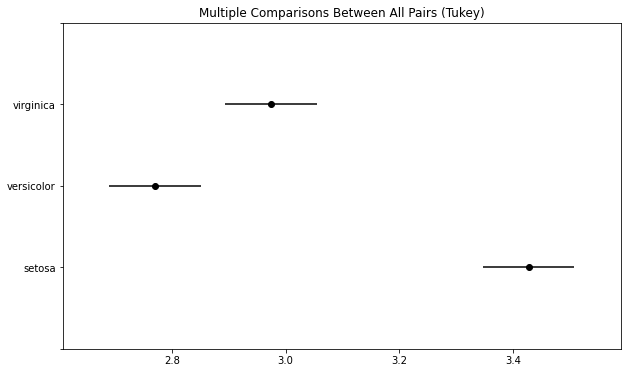

In [12]:
posthoc = pairwise_tukeyhsd( df_iris['Sepal_Width'], df_iris['Species'],
                             alpha=0.05)
print(posthoc)
print()
fig = posthoc.plot_simultaneous()

##### 1.3.1.2. scikit_posthocs 패키지의 posthoc_tukey_hsd() 활용

In [13]:
posthoc = sp.posthoc_tukey_hsd( df_iris['Sepal_Width'],
                                df_iris['Species'],
                                alpha = 0.05)
print(posthoc)
print()

            setosa  versicolor  virginica
setosa           1           1          1
versicolor       1           1          1
virginica        1           1          1



In [14]:
posthoc = sp.posthoc_tukey(  df_iris,
                             val_col = 'Sepal_Width',
                             group_col = 'Species',
                             sort = False )
print(posthoc)
print()

            setosa  versicolor  virginica
setosa       1.000    0.001000   0.001000
versicolor   0.001    1.000000   0.008779
virginica    0.001    0.008779   1.000000



#### 1.3.2. Scheffé’s Method

##### 1.3.2.1. scikit_posthocs 패키지의 posthoc_scheffe() 활용

In [15]:
sp.posthoc_scheffe( df_iris,
                    val_col = 'Sepal_Width',
                    group_col = 'Species',
                    sort = False )

,setosa,versicolor,virginica
setosa,1.000000e+00,1.758878e-16,3.405790e-09
versicolor,1.758878e-16,1.000000e+00,1.258285e-02
virginica,3.405790e-09,1.258285e-02,1.000000e+00


#### 1.3.3. Pairwise T-test

##### 1.3.3.1. scikit_posthocs 패키지의 posthoc_ttest() 활용

In [16]:
sp.posthoc_ttest( df_iris,
                    val_col = 'Sepal_Width',
                    group_col = 'Species',
                    sort = False )

,setosa,versicolor,virginica
setosa,1.000000e+00,1.845260e-15,4.246355e-09
versicolor,1.845260e-15,1.000000e+00,1.819100e-03
virginica,4.246355e-09,1.819100e-03,1.000000e+00


##### 1.3.3.2. statsmodels의 MultiComparison 패키지 및 allpairtest() 활용

In [17]:
comp = MultiComparison( df_one_anova['Sepal_Width'], df_one_anova['Species'] )

# Bonferroni 방법을 통해 모든 그룹간 ttest를 진행
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
setosa,versicolor,9.455,0.0,0.0,True
setosa,virginica,6.4503,0.0,0.0,True
versicolor,virginica,-3.2058,0.0018,0.0055,True


## 2. 이원배치 분산분석

In [18]:
# 데이터프레임 생성

df_mtcars = pd.read_csv('C:/Users/Administrator/GitHub/TIL/ADP_study/rawdata/mtcars.csv')
df_mtcars.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


### 2.1. 등분산 검정
< 가설 설정 - 등분산성 검정 >
- 귀무가설(H0) : 세 집단의 분산이 동일하다.
- 대립가설(H1) : 적어도 한 집단의 분산이 동일하지 않다.

< 유의수준은 0.05 로 설정 >

#### 1.1.1. Bartlett's test

In [19]:
bartlett_test = stats.bartlett( df_mtcars['am'], df_mtcars['cyl'], df_mtcars['mpg'] )

print( f" Statistic(Bartlett's test): {bartlett_test[0]:.3f} \n P-value: {bartlett_test[1]:.12f} " )

if bartlett_test[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.")
if bartlett_test[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.")
print()

 Statistic(Bartlett's test): 134.195 
 P-value: 0.000000000000 
 p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.



### 2.2. two-way ANOVA

< 가설 설정 - ANOVA >

1. 주효과 검정에 대한 가설  
a. 귀무가설(H0) : 실린더 개수에 따른 주행거리 차이는 존재하지 않는다.  
a. 대립가설(H1) : 실린더 개수에 따른 주행거리 차이가 존재한다.  
b. 귀무가설(H0) : 변속기 종류에 따른 주행거리 차이는 존재하지 않는다.  
b. 대립가설(H1) : 변속기 종류에 따른 주행거리 차이가 존재한다.

2) 상호작용효과 검정에 대한 가설
- 귀무가설(H0) : 변속기 종류와 실린더 개수 간에는 상호작용 효과가 없다.
- 대립가설(H1) : 변속기 종류와 실린더 개수 간에는 상호작용 효과가 있다.

< 유의수준은 0.05 로 설정 >

#### 2.2.1. pingouin 패키지 사용

In [20]:
results = pg.anova( data = df_mtcars,
                    dv = 'mpg', between = ['am','cyl'] )

print(results)

     Source          SS    DF          MS          F         p-unc       np2
0        am   36.766919   1.0   36.766919   3.998759  5.608373e-02  0.133297
1       cyl  456.400921   2.0  228.200461  24.819011  9.354735e-07  0.656258
2  am * cyl   25.436511   2.0   12.718256   1.383233  2.686140e-01  0.096170
3  Residual  239.059167  26.0    9.194583        NaN           NaN       NaN


#### 2.2.2. statsmodels 패키지 사용

In [21]:
df_anova = pd.DataFrame(df_mtcars)

results = ols( 'mpg ~ C(am)*C(cyl)', data = df_anova ).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     19.29
Date:                Fri, 16 Jul 2021   Prob (F-statistic):           5.18e-08
Time:                        22:10:32   Log-Likelihood:                -77.582
No. Observations:                  32   AIC:                             167.2
Df Residuals:                      26   BIC:                             176.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 22

### 2.3. 사후 검정

#### 2.3.2. Scheffé’s Method

In [22]:
print( 'mpg - am')
result1 = sp.posthoc_scheffe( df_mtcars,
                              val_col = 'mpg',
                              group_col = 'am',
                              sort = False )
print(result1)
print()

print( 'mpg - cyl')
result2 = sp.posthoc_scheffe( df_mtcars,
                              val_col = 'mpg',
                              group_col = 'cyl',
                              sort = False )
print(result2)
print()

print( 'am - cyl')
result3 = sp.posthoc_scheffe( df_mtcars,
                              val_col = 'am',
                              group_col = 'cyl',
                              sort = False )
print(result3)

mpg - am
          1         0
1  1.000000  0.000285
0  0.000285  1.000000

mpg - cyl
          6             4             8
6  1.000000  5.402324e-04  1.533399e-02
4  0.000540  1.000000e+00  5.048916e-09
8  0.015334  5.048916e-09  1.000000e+00

am - cyl
          6         4         8
6  1.000000  0.385071  0.385744
4  0.385071  1.000000  0.009877
8  0.385744  0.009877  1.000000


#### 2.3.3. 상호작용효과 그래프

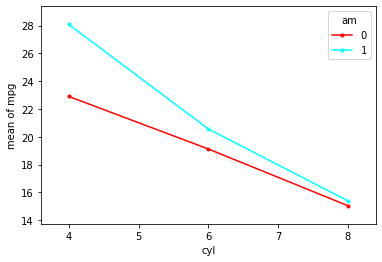

In [23]:
fig = interaction_plot( x = df_mtcars['cyl'],
                        trace = df_mtcars['am'],
                        response = df_mtcars['mpg'] )

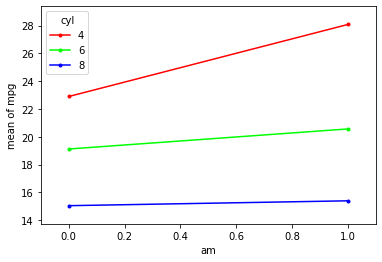

In [24]:
fig = interaction_plot( x = df_mtcars['am'],
                        trace = df_mtcars['cyl'],
                        response = df_mtcars['mpg'] )